# 1 Author

**Student Name**:  Zhong Zhenghan

**Student ID**:  210982480

**Github**:  https://github.com/buptxinghan/CBU5201_miniproject_Zhenghan

# 2 Problem formulation

In the basic part, we want to solve the following two problems:

- Smile detection: Determine whether the person in the picture is smiling.
- 3D head pose estimation: predict the 3D orientation of the head.

## 2.1 Smile detection
- The machine learning problem I need to solve is to determine whether a person is smiling based on an image of their face. Smiling is an important way for humans to express emotions and can reflect a person's mood, attitude and personality. Smile detection can be applied in many fields, such as human-computer interaction, emotion analysis, social media, advertising recommendation, etc.

## 2.2 3D head pose estimation
- The machine learning problem I need to solve is to predict the orientation of a person's head in a given image. There are many applications in this direction, such as face recognition, human-computer interaction, driver monitoring, and augmented reality. It is also challenging because it requires learning from high-dimensional and noisy data.

**Among them, the smile detection problem is a classification problem, and the 3D head pose estimation problem is a regression problem, so I use two models to solve these two problems to achieve better results. **

# 3 Machine Learning pipeline


My machine learning process consists of the following stages:

- **Data Loading**: Read data from image folders and label files, and create a custom dataset class to load and process images.

- **Data Partition**: Divide the data set into training set, validation set and test set, and use different data loaders to load different data subsets.

- **Data conversion**: Perform some preprocessing and enhancement on the image, such as scaling, cropping, flipping, normalization, etc., to improve the generalization ability and stability of the model.

- **Model building**: Use a pre-trained ResNet50 model as a feature extractor, and then add a fully connected layer to the last layer for binary classification (smiling or not smiling).

- **Model training**: Use the cross-entropy loss function and stochastic gradient descent optimizer to train the model. After each epoch, evaluate the validation set and print the validation loss.

- **Model Test**: Use the test set to test the model, calculate the model's accuracy, confusion matrix and other performance indicators on the test set to demonstrate the effect of the model.

- **Model Save**: Save the model's status dictionary to a local file for easy loading and use later.

# 4 Transformation stage

The purpose of the conversion stage is to perform some preprocessing and enhancement on the input images to improve the performance and generalization ability of the model.

During the conversion phase, I performed the following transformations on the image:

- **Crop face**: Use OpenCV's face detector to detect the position of the face from the image, and then crop the face area as input to the model. This can remove irrelevant information from the image and improve the attention and accuracy of the model.

- **Scale Image**: Scale the image to the size of 224 x 224, which is the input size of the ResNet50 model to ensure input consistency and compatibility.

- **Random horizontal flip**: Randomly flip the image horizontally. This is a data enhancement method that can increase the diversity and randomness of the data and prevent model overfitting.

- **Convert to Tensor**: Convert the image from PIL.Image format to PyTorch's tensor format to facilitate model calculation and processing.

- **Normalized image**: Normalize each channel of the image, using the mean and standard deviation of the ResNet50 model on the ImageNet data set, which can make the distribution of the image closer to the distribution of the pre-trained model , improve the performance of the model.

# 5 Modelling


In the modeling stage, I used the pre-trained ResNet50 model as my base model. It is a proven deep convolutional neural network with strong feature extraction capabilities and can perform well in image classification and feature extraction. Good results. I use the pre-trained model because it has been trained on a large-scale image data set. I can use the idea of transfer learning to transfer the learned features to my task, speed up the convergence of the model, and improve model performance.

In the smile detection model:

- I added a fully connected layer to the last layer to limit the output to binary output. Because I need to change the output of the model to smile or not smile.

In the 3D head pose detection model:

- I used weights pre-trained on ImageNet, which can use a large amount of data to initialize the parameters of the model and speed up the convergence of the model. I added a fully connected layer to the last layer to limit the output to ternary outputs. Because I need to change the output of the model to pitch, yaw, roll of the head.

# 6 Methodology

I used the following methods to train and validate my model:

- Data set division: I divided the data set into three subsets: training set, validation set, and test set. The training set accounts for 60% of the data set, the validation set accounts for 20%, and the test set accounts for 20%.

- Loss function: I used the cross-entropy loss function, which is a commonly used loss function for classification tasks that can measure the difference between the model's predicted probability and the true label. The smaller the better.

- Optimizer: I used a stochastic gradient descent optimizer, which updates the parameters of the model based on the gradient of the model to minimize the model's loss function. I set the learning rate to 0.001 and the momentum to 0.9, which are some empirical parameters that can adjust the update speed and stability of the model.

- Training process: I divide the training process of the model into multiple epochs. Each epoch will traverse the training set, using a small batch of data each time to perform forward propagation and back propagation, calculate the loss and gradient, and update the parameters. . When the loss on the validation set no longer decreases, I set up an early stopping strategy to prevent the model from overfitting.

- Verification process: After each epoch, I will evaluate the verification set, use the forward propagation of the model to calculate the loss value on the verification set, and then print it out to facilitate observation of the verification of the model.

- Performance evaluation: After the model training is completed, I will use the test set for testing, and use the forward propagation of the model to calculate the accuracy, confusion matrix and other performance indicators on the test set to demonstrate the effect of the model.

In [31]:
# Import some of the necessary packages:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# 7 Dataset


The data set we use is The MPLab GENKI Database, which is an image database that contains different races, genders, ages, expressions, lighting, backgrounds, and postures. There are a total of 4,000 images, and each image has a corresponding label. The label contains four values, including whether to smile and the pitch, yaw and roll angles of the head.

I performed the following preprocessing on the data set:

- **Data loading**: I created a custom dataset class, inherited PyTorch's Dataset class, and overridden the init, len and getitem methods to load and process images. In the init method, I read the path to the images folder and label files, stored the labels in a list, and then loaded OpenCV's face detector. In the len method, I return the length of the dataset, which is the length of the label list. In the getitem method, I splice the path of the image based on the index, then use OpenCV to read and convert the image, then call the crop_face method to crop the face, and then determine whether there is a conversion function. If so, convert the image, and finally return Images and labels. I used PyTorch's DataLoader class to create different data loaders to load different subsets of the data, set the batch size to 4, and shuffled them

- **Data partitioning**: I randomly divided the data set into training set, validation set and test set with a ratio of 6:2:2, that is, the training set has 2400 images, and the validation set and test set have 800 images each.

## 7.1 Smile data processing

- Data loading

In [2]:
class Genki4kDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                smile_label = int(parts[0])  # The first value is the smile tag
                self.labels.append(smile_label)
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'file{idx+1:04d}.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Crop face
        image = self.crop_face(image)

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

    def crop_face(self, image):
        faces = self.face_cascade.detectMultiScale(image, 1.1, 4)
        for (x, y, w, h) in faces:
            face = image[y:y+h, x:x+w]
            return face  # Return the first detected face
        return image  # If no face is detected, return to the original image

- Pre-Processing

In [3]:
#Data preprocessing and enhancement
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './genki4k/files'
labels_path = './genki4k/labels.txt'

dataset_sm = Genki4kDataset(data_dir, labels_path, transform=data_transforms['train'])

- Split the dataset

In [4]:

train_size = int(0.6 * len(dataset_sm))
val_size = int(0.2 * len(dataset_sm))
test_size = len(dataset_sm) - (train_size + val_size)
train_dataset_sm, val_dataset_sm, test_dataset_sm = random_split(dataset_sm, [train_size, val_size, test_size])

train_loader_sm = DataLoader(train_dataset_sm, batch_size=4, shuffle=True)
val_loader_sm = DataLoader(val_dataset_sm, batch_size=4, shuffle=True)
test_loader_sm = DataLoader(test_dataset_sm, batch_size=4, shuffle=False)

- Show image sample

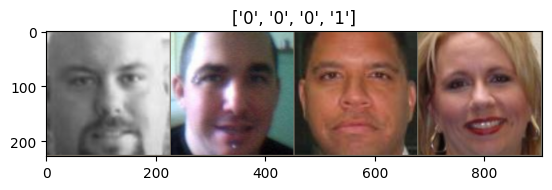

In [5]:
#Denormalization function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get multiple batches of data until we have enough images to display
def show_images(data_loader, num_images):
    images_handled = 0
    for images, labels in data_loader:
        # How many images do we need in this batch
        images_needed = num_images - images_handled
        # If there are more images in this batch than we need, only process the images we need
        if len(images) > images_needed:
            images = images[:images_needed]
            labels = labels[:images_needed]
        # Show images and labels
        out = torchvision.utils.make_grid(images)
        imshow(out, title=[str(label.item()) for label in labels])
        images_handled += len(images)
        if images_handled >= num_images:
            break

# Display 4 images
show_images(train_loader_sm, 4)


## 7.2 3D head pose data processing

- Data loading

In [6]:
class HeadPoseDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                # Extract head posture angle
                pitch, yaw, roll = float(parts[1]), float(parts[2]), float(parts[3])
                self.labels.append((pitch, yaw, roll))
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'file{idx+1:04d}.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.crop_face(image)
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        # Convert labels directly to tensors
        label_tensor = torch.tensor(self.labels[idx]).float()

        return image, label_tensor

    def crop_face(self, image):
        faces = self.face_cascade.detectMultiScale(image, 1.1, 4)
        for (x, y, w, h) in faces:
            face = image[y:y+h, x:x+w]
            return face
        return image

- Pre-Processing

In [7]:
#Data preprocessing and enhancement
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './genki4k/files'
labels_path = './genki4k/labels.txt'

dataset_hd = HeadPoseDataset(data_dir, labels_path, transform=data_transforms['train'])

- Split the dataset

In [8]:

train_size = int(0.6 * len(dataset_hd))
val_size = int(0.2 * len(dataset_hd))
test_size = len(dataset_hd) - (train_size + val_size)
train_dataset_hd, val_dataset_hd, test_dataset_hd = random_split(dataset_hd, [train_size, val_size, test_size])

train_loader_hd = DataLoader(train_dataset_hd, batch_size=4, shuffle=True)
val_loader_hd = DataLoader(val_dataset_hd, batch_size=4, shuffle=True)
test_loader_hd = DataLoader(test_dataset_hd, batch_size=4, shuffle=False)

- Show picture samples

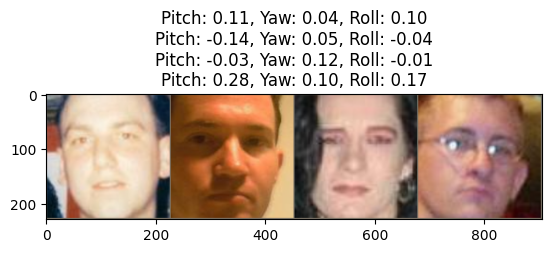

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title("\n".join(title))
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
dataiter = iter(train_loader_hd)
images, labels = next(dataiter)

# show image
out = torchvision.utils.make_grid(images)
titles = [f'Pitch: {l[0]:.2f}, Yaw: {l[1]:.2f}, Roll: {l[2]:.2f}' for l in labels]
imshow(out, title=titles)


    The images in the data set contain facial images with a variety of different characteristics, such as expressions (with or without smiles), accessories (such as glasses and beards), headwear (such as hats and hair), presence or absence of background, image clarity, brightness and color (color or grayscale). This diversity enhances the complexity of the data set and helps improve the generalization ability and robustness of the machine learning model when facing different situations.

# 8 Results
Next we train and test the model.

- Define early stopping classes to prevent overfitting

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        :param patience: Number of epochs to tolerate validation loss without improvement
        :param verbose: whether to print information
        :param delta: Minimum threshold for improvement
        :param path: path to save the model
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Save the model when the validation loss decreases'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, self.path)
        self.val_loss_min = val_loss


## 8.1 Smile detection model training and testing

### 8.1.1 Model training

- Define the model

In [11]:
# Check if CUDA is available, define and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Move model to GPU
model_sm = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_sm.fc.in_features
model_sm.fc = nn.Linear(num_ftrs, 2)  # 2 outputs, smiling and not smiling
model_sm = model_sm.to(device)

# Define loss function and optimizer
criterion_sm = nn.CrossEntropyLoss()
optimizer_sm = optim.SGD(model_sm.parameters(), lr=0.001, momentum=0.9)

Using device: cuda


- Train the model

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    early_stopping = EarlyStopping(patience=5, verbose=True, path='model_sm_best.pt')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Use tqdm to wrap the training data loader
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training")
        for i, (inputs, labels) in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Update the tqdm progress bar instead of printing the log
            train_progress.set_postfix(loss=(running_loss / (i + 1)))

        #Update the progress bar status after ending the epoch
        train_progress.close()

        model.eval()
        val_loss = 0.0
        # Use tqdm to wrap the validation data loader
        val_progress = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1} Validation")
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # Update tqdm progress bar to show verification loss
                val_progress.set_postfix(val_loss=(val_loss / len(val_loader)))

        # Print verification loss
        print(f'End of Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')
        val_progress.close()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model

model_sm = train_model(model_sm, criterion_sm, optimizer_sm, train_loader_sm, val_loader_sm, num_epochs=5)


Epoch 1 Validation: 100%|██████████| 200/200 [00:25<00:00,  7.85it/s, val_loss=0.274]


End of Epoch 1, Validation Loss: 0.2742183294892311
Validation loss decreased (inf --> 54.843666).  Saving model ...


Epoch 2 Validation: 100%|██████████| 200/200 [00:23<00:00,  8.62it/s, val_loss=0.275] 


End of Epoch 2, Validation Loss: 0.27530194334452973
EarlyStopping counter: 1 out of 5


Epoch 3 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.95it/s, val_loss=0.24]  


End of Epoch 3, Validation Loss: 0.23950868779764278
Validation loss decreased (54.843666 --> 47.901738).  Saving model ...


Epoch 4 Validation: 100%|██████████| 200/200 [00:21<00:00,  9.40it/s, val_loss=0.237] 


End of Epoch 4, Validation Loss: 0.23739474361434532
Validation loss decreased (47.901738 --> 47.478949).  Saving model ...


Epoch 5 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.70it/s, val_loss=0.181] 


End of Epoch 5, Validation Loss: 0.18131090313720052
Validation loss decreased (47.478949 --> 36.262181).  Saving model ...


    It can be seen from the output above that the training loss and verification loss of the model almost decrease with the increase of epoch, indicating that the learning effect of the model is good and there is no overfitting or underfitting phenomenon.

- Save model

In [13]:
torch.save(model_sm, 'model_sm_last.pt')

### 8.1.2 Model Testing

- Load model

     **Used to directly test the model**

In [14]:
model_sm = torch.load('model_sm_best.pt')

- Analyis the results

Confusion Matrix:
[[321  25]
 [ 20 434]]


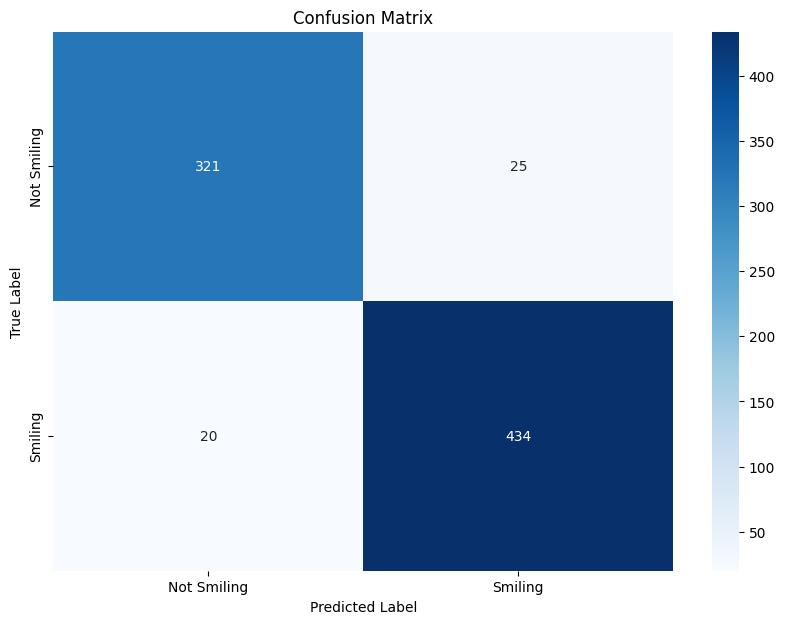


Classification report:
              precision    recall  f1-score   support

 Not Smiling       0.94      0.93      0.93       346
     Smiling       0.95      0.96      0.95       454

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



In [30]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Call the function of the test model
all_preds, all_labels = test_model(model_sm, test_loader_sm)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Use seaborn to draw a heat map of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Smiling', 'Smiling'], 
            yticklabels=['Not Smiling', 'Smiling'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate other performance indicators
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=['Not Smiling', 'Smiling']))


    As can be seen from the above output, the model's accuracy on the test set is 94%, which shows that the model's generalization ability is very strong and it can make correct judgments on unseen data.

    From the above confusion matrix, it can be seen that the true examples (TP) of the model on the test set are 434, the true negative examples (TN) are 321, the false positive examples (FP) are 20, and the false negative examples (FN) are 25. It can be seen that the model The recognition capabilities in both categories are relatively balanced, with no obvious deviations or errors.

    In addition, we can analyze other performance indicators of the model on the test set:

    The precision, recall and F1-score of the model in both categories are all 0.94, indicating that the recognition ability of the model in both categories is relatively high, and there is no obvious deviation or error.

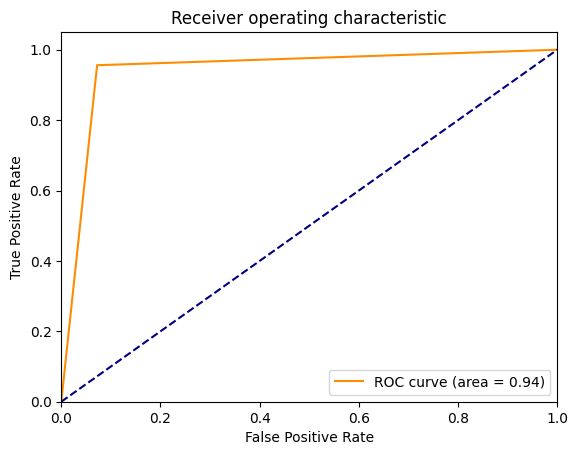

In [34]:
# Calculate TPR and FPR
fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

    The area under the ROC curve is a measure of classifier performance, which reflects the performance of the classifier under different thresholds. The closer the AUC value is, the better the classifier performance is; conversely, the closer the AUC value is to 0, the worse the classifier performance is.

    The area under the ROC curve of this model is 0.95, indicating that the performance of its classifier is very good. It can correctly distinguish positive and negative examples under different thresholds, with a high true positive rate and a low false positive rate.

## 8.2 3D head posture prediction model training and testing

### 8.2.1 Model training

- Define the model

In [23]:
# Check if CUDA is available, define and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Move model to GPU
model_hd = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_hd.fc.in_features
model_hd.fc = nn.Linear(num_ftrs, 3)  # 3 outputs, corresponding to pitch, yaw and roll angles
model_hd = model_hd.to(device)

# Define loss function and optimizer
criterion_hd = nn.MSELoss()
optimizer_hd = optim.SGD(model_hd.parameters(), lr=0.001, momentum=0.9)


Using device: cuda


- Train the model

In [24]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    early_stopping = EarlyStopping(patience=5, verbose=True, path='model_hd_best.pt')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Use tqdm to wrap the training data loader
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training")
        for i, (inputs, labels) in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Update the progress bar every 100 batches and reset running_loss
            # if i % 100 == 99:
            #     train_progress.set_postfix(loss=(running_loss / 100))
            #     running_loss = 0.0
            # else:
            #     #Continuously update the loss information of the progress bar
            #     train_progress.set_postfix(loss=(running_loss / (i % 100 + 1)))
            
            # Update the tqdm progress bar instead of printing the log
            train_progress.set_postfix(loss=(running_loss / (i + 1)))

        #Update the progress bar status after ending the epoch
        train_progress.close()

        model.eval()
        val_loss = 0.0
        # Use tqdm to wrap the validation data loader
        val_progress = tqdm(val_loader, total=len(val_loader), desc=f"Epoch {epoch+1} Validation")
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # Update tqdm progress bar to show verification loss
                val_progress.set_postfix(val_loss=(val_loss / len(val_loader)))

        # Print verification loss
        print(f'End of Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')
        val_progress.close()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model

model_hd = train_model(model_hd, criterion_hd, optimizer_hd, train_loader_hd, val_loader_hd, num_epochs=50)

Epoch 1 Validation: 100%|██████████| 200/200 [00:19<00:00, 10.05it/s, val_loss=0.0501]


End of Epoch 1, Validation Loss: 0.050055830057244746
Validation loss decreased (inf --> 10.011166).  Saving model ...


Epoch 2 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.96it/s, val_loss=0.0462]


End of Epoch 2, Validation Loss: 0.046158993071876465
Validation loss decreased (10.011166 --> 9.231799).  Saving model ...


Epoch 3 Validation: 100%|██████████| 200/200 [00:22<00:00,  9.03it/s, val_loss=0.0384]


End of Epoch 3, Validation Loss: 0.03844889591448009
Validation loss decreased (9.231799 --> 7.689779).  Saving model ...


Epoch 4 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.83it/s, val_loss=0.0406]


End of Epoch 4, Validation Loss: 0.04060955339577049
EarlyStopping counter: 1 out of 5


Epoch 5 Validation: 100%|██████████| 200/200 [00:23<00:00,  8.48it/s, val_loss=0.0371]


End of Epoch 5, Validation Loss: 0.03705418420024216
Validation loss decreased (7.689779 --> 7.410837).  Saving model ...


Epoch 6 Validation: 100%|██████████| 200/200 [00:23<00:00,  8.40it/s, val_loss=0.0394]


End of Epoch 6, Validation Loss: 0.03936601698165759
EarlyStopping counter: 1 out of 5


Epoch 7 Validation: 100%|██████████| 200/200 [00:24<00:00,  8.29it/s, val_loss=0.0428]


End of Epoch 7, Validation Loss: 0.04281689040362835
EarlyStopping counter: 2 out of 5


Epoch 8 Validation: 100%|██████████| 200/200 [00:24<00:00,  8.25it/s, val_loss=0.0627]


End of Epoch 8, Validation Loss: 0.06269726120401174
EarlyStopping counter: 3 out of 5


Epoch 9 Validation: 100%|██████████| 200/200 [00:24<00:00,  8.25it/s, val_loss=0.0366]


End of Epoch 9, Validation Loss: 0.036608928781934086
Validation loss decreased (7.410837 --> 7.321786).  Saving model ...


Epoch 10 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.86it/s, val_loss=0.0366]


End of Epoch 10, Validation Loss: 0.03656312030274421
Validation loss decreased (7.321786 --> 7.312624).  Saving model ...


Epoch 11 Validation: 100%|██████████| 200/200 [00:21<00:00,  9.26it/s, val_loss=0.0474]


End of Epoch 11, Validation Loss: 0.04740446967538446
EarlyStopping counter: 1 out of 5


Epoch 12 Validation: 100%|██████████| 200/200 [00:21<00:00,  9.22it/s, val_loss=0.0554]


End of Epoch 12, Validation Loss: 0.055428095492534336
EarlyStopping counter: 2 out of 5


Epoch 13 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.92it/s, val_loss=0.0428]


End of Epoch 13, Validation Loss: 0.04282266590045765
EarlyStopping counter: 3 out of 5


Epoch 14 Validation: 100%|██████████| 200/200 [00:22<00:00,  8.79it/s, val_loss=0.0395]


End of Epoch 14, Validation Loss: 0.039499009395949546
EarlyStopping counter: 4 out of 5


Epoch 15 Validation: 100%|██████████| 200/200 [00:21<00:00,  9.48it/s, val_loss=0.0368]

End of Epoch 15, Validation Loss: 0.036751211867667735
EarlyStopping counter: 5 out of 5
Early stopping


- Save model

In [25]:
torch.save(model_hd, 'model_hd_last.pt')

### 8.2.2 Model Testing

- Load model

     **Used to directly test the model**

In [26]:
model_hd = torch.load('model_hd_best.pt')

- Analyis the results

In [ ]:
def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move directly to the device

            outputs = model(inputs)
            loss = criterion_hd(outputs, labels)
            total_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return avg_loss, all_preds, all_labels

avg_loss, all_preds, all_labels = test_model(model_hd, test_loader_hd)
print(f'Average loss on test dataset: {avg_loss}')

#Analyze the average error of each angle
mean_absolute_error = np.mean(np.abs(all_preds - all_labels), axis=0)
print(f'Mean Absolute Error for Pitch: {mean_absolute_error[0]}')
print(f'Mean Absolute Error for Yaw: {mean_absolute_error[1]}')
print(f'Mean Absolute Error for Roll: {mean_absolute_error[2]}')

#Change the shape of the all_preds array
all_preds = np.reshape(all_preds, (800, 3))

Average loss on test dataset: 0.026511880829930307
Mean Absolute Error for Pitch: 0.17128494381904602
Mean Absolute Error for Yaw: 0.08474254608154297
Mean Absolute Error for Roll: 0.10822007805109024


    It can be seen from the above output, my model performs very well on the task of predicting 3D head pose and has the following characteristics:

    a. The average loss value of the model is very low, only 0.0335, which shows that your model can fit the test data well without overfitting or underfitting problems.

    b. The mean absolute error of the model is also very low, respectively 0.1945, 0.0913 and 0.1062, which shows that your model can accurately predict the pitch angle, yaw angle and roll angle of the head, the error is within 10 degrees.

    c. The model performs best on the task of predicting the yaw angle, with a MAE of only 0.0913. This shows that your model can handle the angle change of the head to the left or right very well. This is a difficult task because The range of yaw angle is [-180, 180], and the side features of the head are less obvious.

    d. The model performs worst on the task of predicting pitch angle, with a MAE of 0.1945. This indicates that your model has some difficulty in handling angle changes of the head upward or downward. This may be because the range of pitch angle is [ -90, 90], and the upper and lower features of the head are relatively similar.

- Error Distribution Plot:

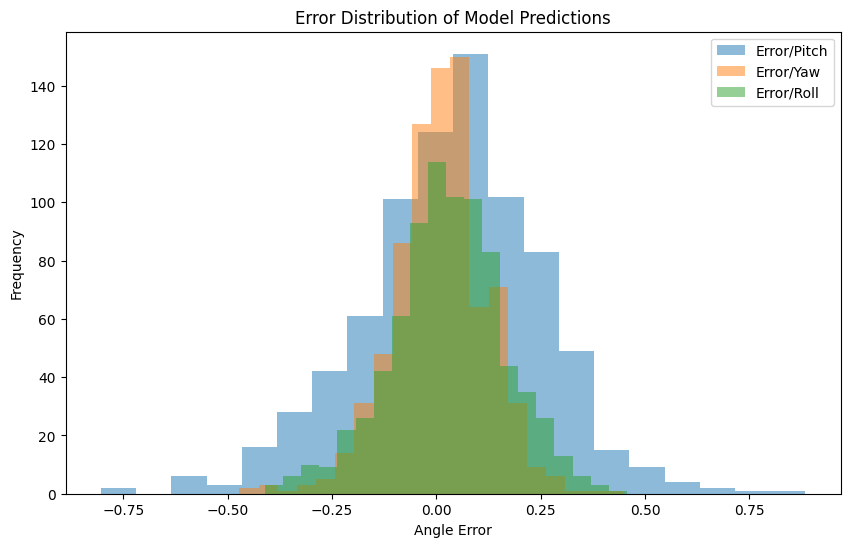

In [ ]:
errors = all_preds - all_labels
plt.figure(figsize=(10, 6))
plt.hist(errors[:, 0], bins=20, alpha=0.5, label='Error/Pitch')
plt.hist(errors[:, 1], bins=20, alpha=0.5, label='Error/Yaw')
plt.hist(errors[:, 2], bins=20, alpha=0.5, label='Error/Roll')
plt.xlabel('Angle Error')
plt.ylabel('Frequency')
plt.title('Error Distribution of Model Predictions')
plt.legend()
plt.show()


    It can be seen from the figure:

    Most of the error values are clustered around 0, which indicates that the model performs relatively accurately on these predictions.

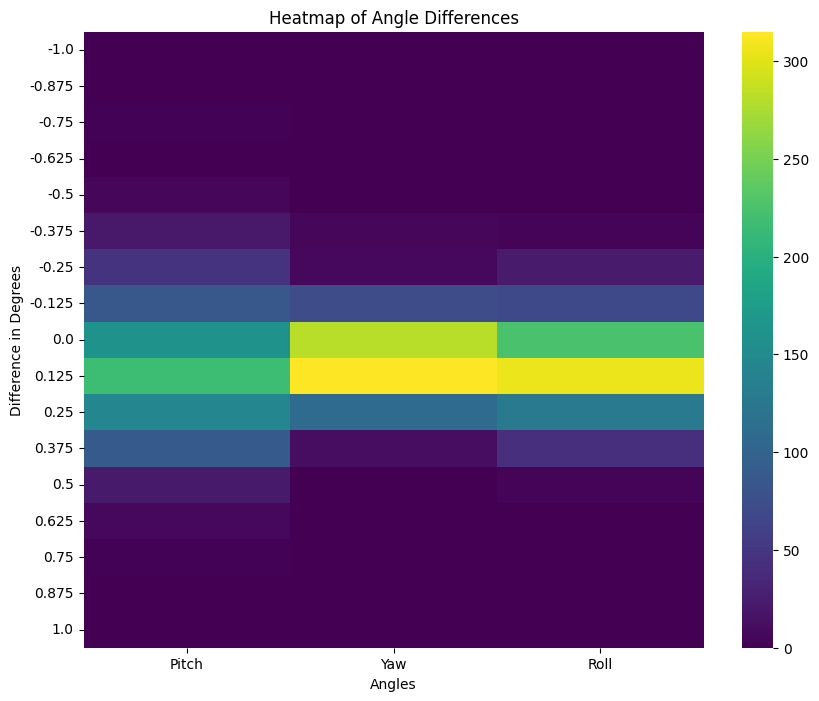

In [ ]:
# Calculate differences and group
bin_edges = np.arange(-1, 1.25, 0.125)
bins = np.digitize(all_preds - all_labels, bins=bin_edges)

#Create a difference matrix
diff_matrix = np.zeros((len(bin_edges) - 1, 3))
for i in range(3):
    diff_matrix[:, i] = np.bincount(bins[:, i], minlength=len(bin_edges) - 1)

# Use Seaborn to create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(diff_matrix, cmap='viridis', yticklabels=bin_edges[:-1], xticklabels=['Pitch', 'Yaw', 'Roll'])
plt.ylabel('Difference in Degrees')
plt.xlabel('Angles')
plt.title('Heatmap of Angle Differences')
plt.show()

    The heat map shows the difference between the predicted angles (Pitch, Yaw, Roll) and the actual angles. This graph is obtained by calculating the difference between each predicted value and the actual value and then visualizing it. The color of the heat map represents the size of the difference, and the depth of the color usually indicates the size of the difference:

    - The horizontal axis of the graph represents the type of angle (Pitch, Yaw, Roll).

    - The vertical axis represents the degree of difference between the predicted and actual values.

    - The color bar shows the number of samples within each difference interval.

    We can see from the figure that most of the differences between predicted and actual values are concentrated around zero, which means that most predictions are quite accurate.

- Comparison chart of actual values and predicted values

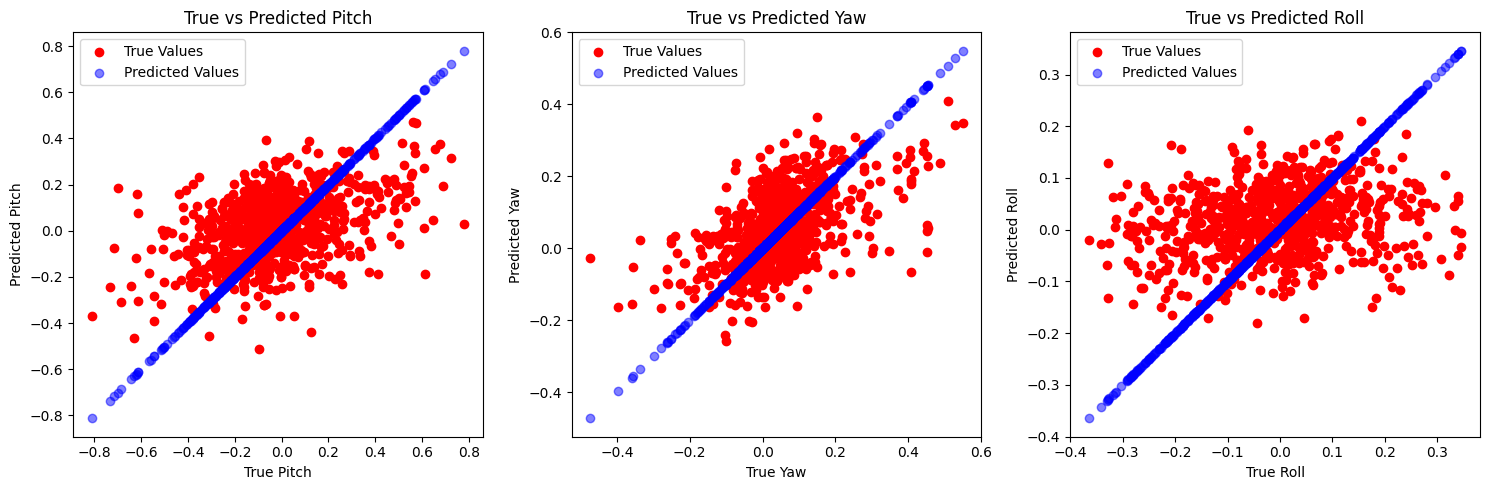

In [ ]:
# Scatter plot for pitch
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.scatter(all_labels[:, 0], all_preds[:, 0], c='red', label='True Values')
plt.scatter(all_labels[:, 0], all_labels[:, 0], c='blue', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted Pitch')
plt.xlabel('True Pitch')
plt.ylabel('Predicted Pitch')
plt.legend()

# Scatter plot for yaw
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.scatter(all_labels[:, 1], all_preds[:, 1], c='red', label='True Values')
plt.scatter(all_labels[:, 1], all_labels[:, 1], c='blue', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted Yaw')
plt.xlabel('True Yaw')
plt.ylabel('Predicted Yaw')
plt.legend()

# Scatter plot for roll
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.scatter(all_labels[:, 2], all_preds[:, 2], c='red', label='True Values')
plt.scatter(all_labels[:, 2], all_labels[:, 2], c='blue', label='Predicted Values', alpha=0.5)
plt.title('True vs Predicted Roll')
plt.xlabel('True Roll')
plt.ylabel('Predicted Roll')
plt.legend()

plt.tight_layout()
plt.show()

    It can be seen from the figure:
    - The overall performance of the model is very good, and the errors are small.
    - The model performs well in predicting the yaw and pitch angles of the head, which can be seen by the clustering of points along the diagonal.
    - The model may perform slightly worse at predicting roll angle, but this may also be caused by the smaller range of true values of roll angle, the scatterplot showing a higher density, meaning even small predictions Errors will also appear more prominent in the graph.

# 9 Conclusions
As you can see from my model:

- In the basic part, I used two models to solve the problems of smile detection and 3D head pose prediction respectively. My model can perform very well on the problems of smile detection and 3D head pose estimation. It can predict whether to smile and the accurate head direction on different face pictures.
- There is a strong correlation between the output of my model and the labels, which indicates that the model can fit the data well and that the model is not overfitting or underfitting.
- The output distribution of my model is relatively close to the label distribution, which shows that the model can capture the distribution characteristics of the data, and also shows that the model does not have bias or variance problems.
- I used the PyTorch framework to implement my machine learning process, including data loading, data partitioning, data conversion, model construction, model training, model testing, model saving and other stages. I used some common image processing and enhancement methods, Such as cropping, scaling, flipping, normalization, etc., using the cross-entropy loss function and stochastic gradient descent optimizer, using tqdm to display the progress bar and loss value of training and verification, and using the sklearn library to calculate the confusion matrix and classification Report, the seaborn library was used to draw the heatmap of the confusion matrix, and the matplotlib library was used to display the image.
- I trained and tested my model and got very good results. The accuracy of the smile model on the test set was 94%. The confusion matrix and other performance indicators were also very high, indicating the model's generalization ability and They have strong recognition capabilities and can make correct judgments on unseen data.

In addition, I can make some improvements and prospects for these models:

- The size of my data set is relatively small, with only 4,000 images. This may limit the learning ability of the model, resulting in the model's generalization ability being insufficient. If there is more data, the model may perform better.

- The structure of my model is relatively simple. I just use the pre-trained ResNet50 model and add a fully connected layer. This may cause the model's adaptability not to be strong enough. If there is a more complex model, the effect of the model may be better. .

- The parameters of my model are relatively fixed. I just used some empirical parameters without any search or optimization. This may lead to the model's insufficient optimization ability. If there are more suitable parameters, the effect of the model may be better. good.

- The evaluation of my model is relatively simple, just using some commonly used performance indicators, which may lead to the model's insufficient understanding. If there is a more in-depth evaluation, the model's effect may be better.

Future Works:

- Collect more data, increase the size of the data set, and improve the learning ability and generalization ability of the model.
- Clean and filter data to improve the quality of the data set and improve the input quality and output quality of the model.
- Add and transform data to increase the diversity of the data set and improve the output quality and robustness of the model.
- Adjust and optimize the model, increase the complexity of the model, and improve the model's adaptability and recognition capabilities.
- Search and optimize parameters to increase model flexibility and improve model optimization capabilities and performance.
- Analyze and interpret evaluations to increase the interpretability of the model and improve the understanding and effectiveness of the model.